# Categorical Variational Autoencoders with MNIST
An autoencoder where the latent code is a concatenation of several one-hot vectors.

- Based on the paper by Jang, Gu, & Poole: https://arxiv.org/abs/1611.01144
- And the tutorial in this blog post: http://blog.evjang.com/2016/11/tutorial-categorical-variational.html?m=1

In [1]:
import numpy as np
import tensorflow as tf

import sys
import time

import load_mnist

%matplotlib inline
from IPython.core.pylabtools import figsize
from seaborn import plt

## Fetch and Read In Data

In [2]:
train_im, test_im, train_labels, test_labels = load_mnist.Datasets()

In [3]:
all_im = np.concatenate([train_im, test_im]).astype(np.float32) / float(train_im.max())

## The Gumbel Softmax Trick

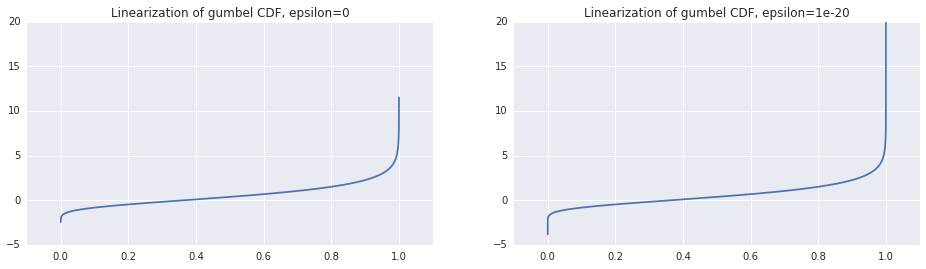

In [4]:
# A linearization of the Gumbel distribution's CDF
# Adding an epsilon prevents input of 0 from throwing an error.
def gumbel_linearization(x, epsilon):
    return -np.log(-np.log(x + epsilon) + epsilon)


figsize(16, 4)
space = np.linspace(0, 1, 100000)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(space, gumbel_linearization(space, epsilon=0))
ax2.plot(space, gumbel_linearization(space, epsilon=1e-20))
for ax, epsilon in zip((ax1, ax2), ("0", "1e-20")):
    ax.set_title("Linearization of gumbel CDF, epsilon=" + epsilon)
    ax.set_xlim(-0.1, 1.1)
    ax.set_ylim(-5, 20)
plt.show()

In [5]:
def sample_gumbel(shape):
    epsilon = 1e-20
    uniform = tf.random_uniform(shape, minval=0, maxval=1)
    return -tf.log(-tf.log(uniform + epsilon) + epsilon)


def gumbel_softmax(logits, temperature):
    return tf.nn.softmax(
        (logits + sample_gumbel(tf.shape(logits))) / temperature)

## The Autoencoder

In [175]:
class GumbelSoftmaxAutoEncoder(object):

    def __init__(
            self, n_encoding_vectors=30, encoding_width=10,
            img_shape=(28, 28), layer_sizes=(512, 256), sess=None):
        self.n_encoding_vectors = n_encoding_vectors
        self.encoding_width = encoding_width
        self.img_shape = img_shape
        self.layer_sizes = layer_sizes

        # Network Initialization
        self.sess = sess or tf.InteractiveSession()
        self._build()
        self.sess.run(tf.initialize_all_variables())

        # Book-keeping
        self.iter_record = []
        self.loss_record = []
        self.loss_components_record = []
        self.lr_record = []
        self.tau_record = []

    def _build_encoder(self):
        enc_layers = [self.x_flat]
        outsizes = list(self.layer_sizes) + [self.n_encoding_vectors * self.encoding_width]
        for i, outsize in enumerate(outsizes):
            enc_layers.append(tf.contrib.layers.fully_connected(
                    enc_layers[-1],
                    outsize,
                    tf.nn.tanh if i < len(self.layer_sizes) else None))
        return enc_layers[1:]

    def _build_decoder(self):
        dec_layers = [self.latent_code]
        outsizes = list(reversed(self.layer_sizes)) + [np.prod(self.img_shape)]
        for i, outsize in enumerate(outsizes):
            dec_layers.append(tf.contrib.layers.fully_connected(
                dec_layers[-1],
                outsize,
                tf.nn.tanh if i < len(self.layer_sizes) else None))
        return dec_layers[1:]

    def _build_loss(self):
        kl_divergence = tf.reduce_sum(
            tf.reshape(
                self.q_y * (self.log_q_y - tf.log(1.0 / self.encoding_width)),
                [-1, self.n_encoding_vectors, self.encoding_width]),
            [1, 2])
        input_prob = tf.reduce_sum(self.p_x.log_prob(self.x_flat), 1)
        elbo = input_prob - kl_divergence
        loss = -tf.reduce_mean(elbo)
        train = tf.train.AdamOptimizer(learning_rate=self.lr).minimize(loss)
        return loss, train, (
            tf.reduce_mean(kl_divergence, name="KL_Divergence"),
            tf.reduce_mean(input_prob, name="Input_Log_Likelihood"))

    def _build(self):
        # Inputs!
        self.x = tf.placeholder(tf.float32, [None] + list(self.img_shape))
        self.x_flat = tf.contrib.layers.flatten(self.x)
        self.lr = tf.placeholder(tf.float32, [])
        self.tau = tf.placeholder(tf.float32, [], name="temperature")

        # Encode!
        self.enc_layers = self._build_encoder()
        self.logits_y = tf.reshape(
            self.enc_layers[-1],
            [-1, self.encoding_width])
        self.q_y = tf.nn.softmax(self.logits_y)
        self.log_q_y = tf.log(self.q_y + 1e-20)
        self.latent_code = tf.reshape(
            gumbel_softmax(self.logits_y, self.tau),
            [-1, self.n_encoding_vectors * self.encoding_width])

        # Decode!
        self.dec_layers = self._build_decoder()
        self.output = tf.reshape(
            tf.nn.sigmoid(self.dec_layers[-1]),
            [-1] + list(self.img_shape))
        self.p_x = tf.contrib.distributions.Bernoulli(logits=self.dec_layers[-1])

        # Loss and training!
        self.loss, self.train, self.loss_components = self._build_loss()

    def fit(
            self, images,
            tau=1.0, lr=0.001, batch_size=100, epochs=1,
            anneal_rate=0.00003, min_temp=0.5, verbose=False):
        ix = np.arange(images.shape[0])
        batches_per_epoch = ix.shape[0] / batch_size
        
        # Iterate through training baches
        for ep in np.arange(epochs):
            if verbose:
                sys.stdout.write("\nStarting epoch {}".format(ep))
                sys.stdout.flush()
            np.random.shuffle(ix)
            for b in np.arange(batches_per_epoch):
                i = (batches_per_epoch * ep) + b
                start = b * batch_size
                stop = start + batch_size
                this_tau = np.maximum(tau * np.exp(-anneal_rate * i), min_temp)
                
                # Update network
                run_result = self.sess.run(
                    [self.train, self.loss] + list(self.loss_components),
                    feed_dict={
                        self.x: images[ix[start:stop]],
                        self.tau: this_tau,
                        self.lr: lr})
                loss = run_result[1]
                loss_components = run_result[2:]
                
                # Book-keeping
                self.iter_record.append(i)
                self.loss_record.append(loss)
                self.loss_components_record.append(loss_components)
                self.lr_record.append(lr)
                self.tau_record.append(this_tau)
                
                # Learning weight decay
                if i % 1000 == 0 and ep > 0:
                    lr *= 0.9
                
                # Status updates
                if verbose and i % 10 == 1:
                    sys.stdout.write(".")
                    sys.stdout.flush()

    def predict(self, images):
        return self.sess.run(
            [self.output],
            feed_dict={
                self.x: images,
                self.tau: 0.0001})[0]

    def show_reconstructions(self, images):
        reconst = self.predict(images)
        figsize(16, 3)
        _, axs = plt.subplots(2, len(images))
        axs_orig, axs_reconst = axs
        for axo, axr, imo, imr in zip(axs_orig, axs_reconst, images, reconst):
            axo.imshow(imo)
            axr.imshow(imr)
            [ax.set_axis_off() for ax in (axo, axr)]
        plt.show()

    def _make_latent_code(self):
        one_hot = np.zeros(self.encoding_width * self.n_encoding_vectors)
        active = np.random.randint(0, self.n_encoding_vectors, self.encoding_width)
        offsets = np.arange(0, 10 * self.encoding_width, 10)
        one_hot[active + offsets] = 1
        return one_hot

    def generate(self, n):
        latent_codes = np.vstack(
            [self._make_latent_code() for _ in np.arange(n)])
        return self.sess.run(
            [self.output],
            feed_dict={
                self.latent_code: latent_codes})[0]

    def show_generated(self, n):
        gen = self.generate(n)
        figsize(15, 0.75 * np.ceil(n / 20.0))
        _, axs = plt.subplots(int(np.ceil(n / 20.0)), 20)
        axs = axs.flatten()
        for ax, im in zip(axs, gen):
            ax.imshow(im)
            ax.set_axis_off()
        plt.show()

    def training_report(self):
        figsize(16, 2.5)
        series = (
            [self.loss_record, self.tau_record, self.lr_record] +
            [s for s in np.array(self.loss_components_record).T])
        names = (
            ["Loss", "Gumbel Softmax Temperature", "Learning Rate"] +
            [v.name.replace("_", " ").rpartition(" ")[0]
             for v in self.loss_components])
        xs = np.arange(len(self.loss_record))
        for n, s in zip(names, series):
            plt.plot(xs, s)
            plt.ylabel(n)
            plt.title("{} by Training Iteration".format(n))
            plt.show()

## Training and Results

In [177]:
#gsae.sess.close()
#del gsae.sess
gsae = GumbelSoftmaxAutoEncoder()

In [178]:
gsae.fit(all_im, epochs=10, verbose=True)


Starting epoch 0......................................................................
Starting epoch 1......................................................................
Starting epoch 2......................................................................
Starting epoch 3......................................................................
Starting epoch 4......................................................................
Starting epoch 5......................................................................
Starting epoch 6......................................................................
Starting epoch 7......................................................................
Starting epoch 8......................................................................
Starting epoch 9......................................................................

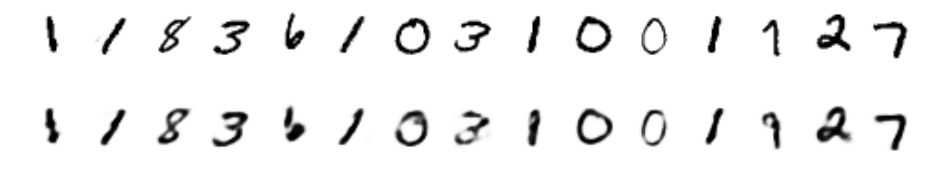

In [179]:
gsae.show_reconstructions(all_im[200:215])

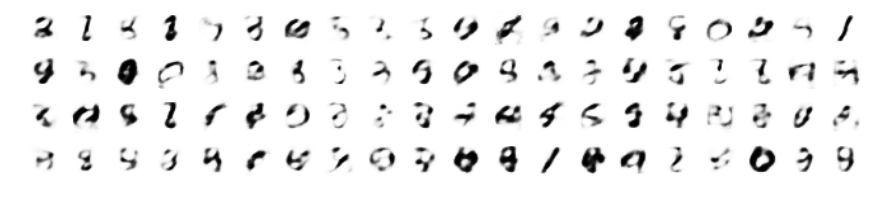

In [180]:
gsae.show_generated(80)

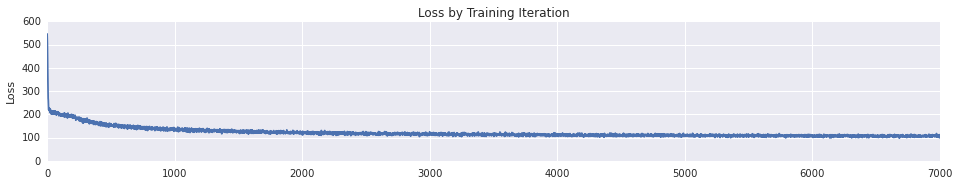

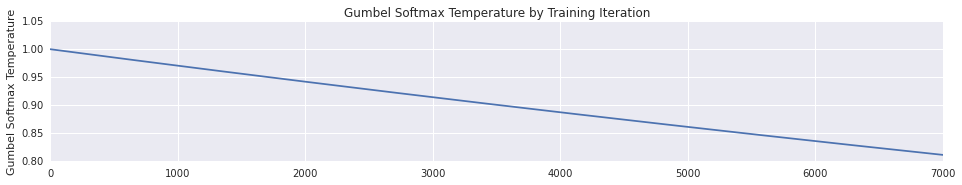

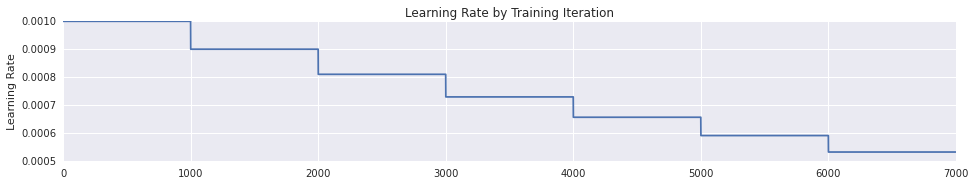

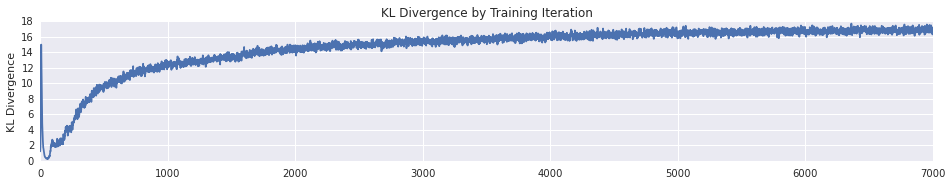

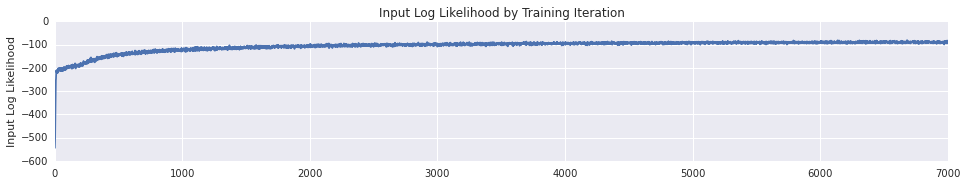

In [181]:
gsae.training_report()

## Convolutional variant!
Conv / max pool in the encoder, and resize / conv in the decoder (as suggested for avoiding checkerboard artifacts by http://distill.pub/2016/deconv-checkerboard/).

In [248]:
class ConvGSAE(GumbelSoftmaxAutoEncoder):

    def _build_encoder(self):
        if len(self.img_shape) == 2:
            enc_layers = [tf.expand_dims(self.x, -1)]
        else:
            enc_layers = [self.x]
        for chan in self.layer_sizes:
            enc_layers.append(tf.contrib.layers.conv2d(
                enc_layers[-1], chan,
                kernel_size=3,
                padding="VALID",
                activation_fn=tf.nn.tanh))
            enc_layers.append(tf.contrib.layers.max_pool2d(
                enc_layers[-1], 2, 2))
        enc_layers.append(tf.contrib.layers.fully_connected(
            tf.contrib.layers.flatten(enc_layers[-1]),
            self.n_encoding_vectors * self.encoding_width))
        return enc_layers[1:]

    def _build_decoder(self):
        final_channels = self.img_shape[-1] if len(self.img_shape) == 3 else 1
        upscale_factor = 2.0 ** len(self.layer_sizes)
        prism_x = int(np.ceil(self.img_shape[0] / upscale_factor))
        prism_y = int(np.ceil(self.img_shape[1] / upscale_factor))
        proj = tf.reshape(
            tf.contrib.layers.fully_connected(
                self.latent_code,
                prism_x * prism_y * self.layer_sizes[-1]),
            [-1, prism_x, prism_y, self.layer_sizes[-1]])
        dec_layers = [proj]
        for i, chan in enumerate(list(reversed(self.layer_sizes[:-1])) + [final_channels]):
            inp = dec_layers[-1]
            sh = list(np.array([int(x) for x in inp.get_shape()[1:3]]) * 2)
            dec_layers.append(tf.image.resize_nearest_neighbor(inp, sh))
            dec_layers.append(tf.contrib.layers.conv2d(
                dec_layers[-1], chan,
                kernel_size=3,
                padding="SAME",
                activation_fn=tf.nn.tanh if i < len(self.layer_sizes) - 1 else None))
        hw = [int(x) for x in dec_layers[-1].get_shape()[1:3]]
        hoff = (hw[0] - self.img_shape[0]) / 2.0
        woff = (hw[1] - self.img_shape[1]) / 2.0
        crop = dec_layers[-1][
            :, int(np.ceil(hoff)):hw[0] - int(np.floor(hoff)),
            int(np.ceil(woff)):hw[1] - int(np.floor(woff)), :]
        dec_layers.append(tf.contrib.layers.flatten(crop))
        return dec_layers

In [256]:
cgsae = ConvGSAE(sess=gsae.sess, layer_sizes=(32, 64))

In [257]:
cgsae.fit(all_im, epochs=3, verbose=True)


Starting epoch 0......................................................................
Starting epoch 1......................................................................
Starting epoch 2......................................................................

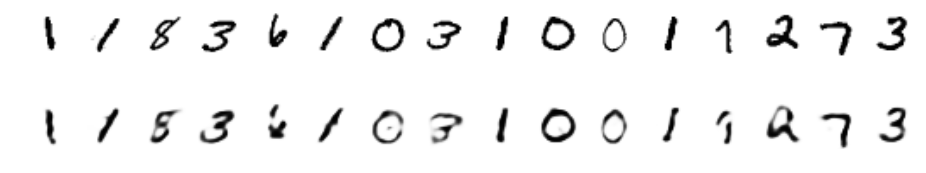

In [261]:
cgsae.show_reconstructions(all_im[200:216])

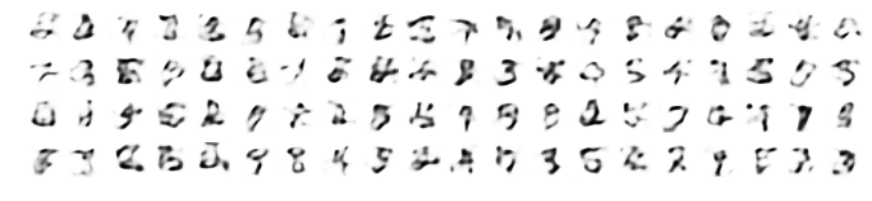

In [259]:
cgsae.show_generated(80)

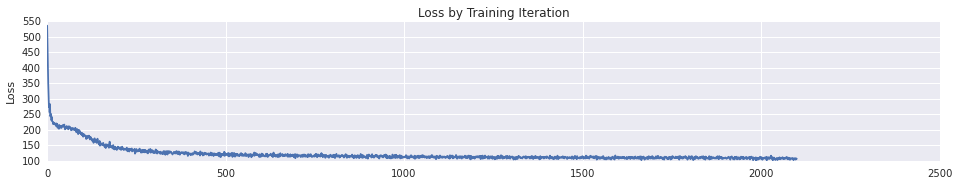

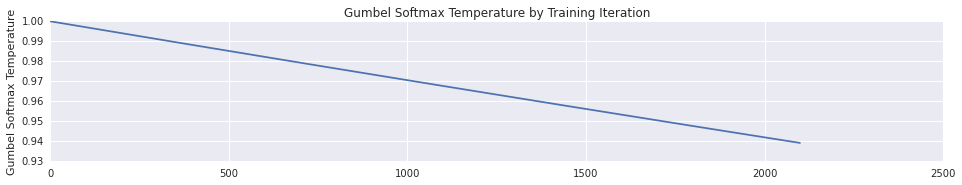

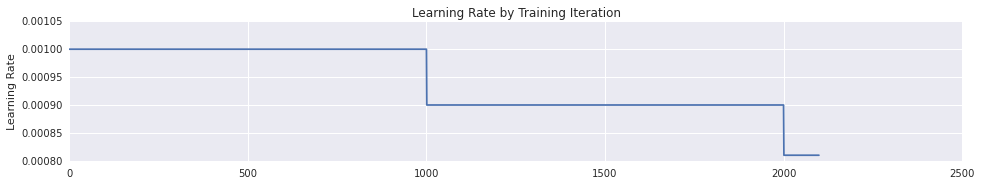

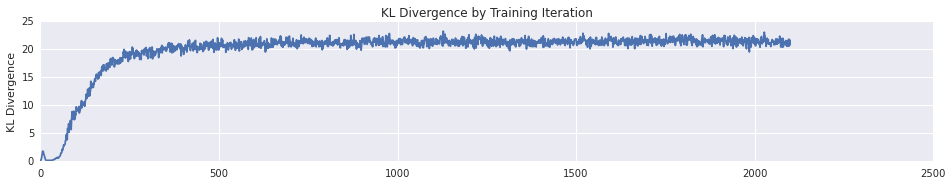

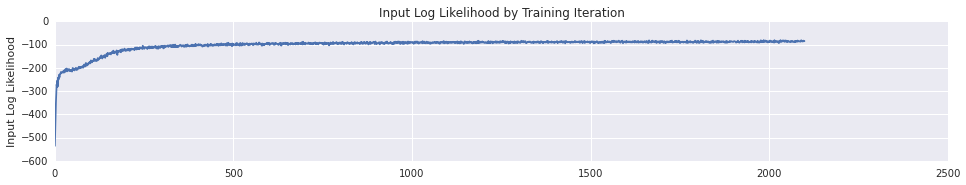

In [260]:
cgsae.training_report()